# **EfficientNetB7 SAGITTAL images**




## SET UP

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os

from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, losses


DATA_CN_AD_PATH = ''
DATA_CN_MCI_AD_PATH = ''

BATCH_SIZE = 32
IMG_SIZE = 224

In [ ]:
def get_datasets_CN_AD():
  data_dir = pathlib.Path(DATA_CN_AD_PATH)

  train_ds = keras.utils.image_dataset_from_directory(
      directory = data_dir,
      subset="training",
      batch_size=BATCH_SIZE,
      image_size=(IMG_SIZE, IMG_SIZE),
      validation_split=0.2,
      seed=123,
      shuffle=True)

  validation_ds = keras.utils.image_dataset_from_directory(
      directory=data_dir,
      subset="validation",
      batch_size=BATCH_SIZE,
      image_size=(IMG_SIZE, IMG_SIZE),
      validation_split=0.2,
      seed=123,
      shuffle=True)
  
  val_batches = tf.data.experimental.cardinality(validation_ds)
  test_dataset = validation_ds.take(val_batches // 5)
  validation_ds = validation_ds.skip(val_batches // 5)

  print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_ds))
  print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

  return train_ds, validation_ds, test_dataset

In [ ]:
def get_datasets_CN_MCI_AD():
  data_dir = pathlib.Path(DATA_CN_MCI_AD_PATH)

  train_ds = keras.utils.image_dataset_from_directory(
      directory = data_dir,
      subset="training",
      batch_size=BATCH_SIZE,
      image_size=(IMG_SIZE, IMG_SIZE),
      validation_split=0.2,
      seed=123,
      shuffle=True,
      label_mode='categorical'
      )

  validation_ds = keras.utils.image_dataset_from_directory(
      directory=data_dir,
      subset="validation",
      batch_size=BATCH_SIZE,
      image_size=(IMG_SIZE, IMG_SIZE),
      validation_split=0.2,
      seed=123,
      shuffle=True,
      label_mode='categorical'
      )
  
  val_batches = tf.data.experimental.cardinality(validation_ds)
  test_dataset = validation_ds.take(val_batches // 5)
  validation_ds = validation_ds.skip(val_batches // 5)

  print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_ds))
  print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

  return train_ds, validation_ds, test_dataset

In [ ]:
def improve_performance(train_ds, validation_ds, test_ds):
  # Caching and Prefetching

  AUTOTUNE = tf.data.AUTOTUNE

  train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
  validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)
  test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

  return train_ds, validation_ds, test_ds

In [ ]:
def showEvolution(acc, val_acc, loss, val_loss, title):
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title(title+' Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title(title+' Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

In [ ]:
def showEvolutionFineTune(acc, val_acc, loss, val_loss, initial_epochs, title):
  plt.style.use('bmh')
  plt.style.use('dark_background')
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, 'fuchsia', label='Training Accuracy', )
  plt.plot(val_acc, 'springgreen', label='Validation Accuracy')
  plt.ylim([0.0, 1])
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(), 
           'deepskyblue', label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title(title+'  Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss,'fuchsia',label='Training Loss')
  plt.plot(val_loss, 'springgreen', label='Validation Loss')
  plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(),
           'deepskyblue', label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title(title+'  Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

# TL Y FT (CN vs AD)

In [ ]:
def CN_AD_model():
  train_ds, validation_ds, test_ds = get_datasets_CN_AD()

  global train_dataset_CN_AD
  global validation_dataset_CN_AD
  global test_dataset_CN_AD
  global class_names_CN_AD

  train_dataset_CN_AD = train_ds
  validation_dataset_CN_AD = validation_ds
  test_dataset_CN_AD = test_ds
  class_names_CN_AD = train_ds.class_names
  print(class_names_CN_AD)

  train_ds, validation_ds, test_ds = improve_performance(train_ds, validation_ds, test_ds)


  data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
  ])
  preprocess_input = tf.keras.applications.efficientnet.preprocess_input
  
  # crear el modelo base pre-entrenado:
  # include_top=False permite la extracción de características eliminando la última capa densa
  IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
  base_model = EfficientNetB7(
      include_top=False,
      weights='imagenet',
      input_shape=IMG_SHAPE
  )

  image_batch, label_batch = next(iter(train_dataset_CN_AD))
  feature_batch = base_model(image_batch)
  print(feature_batch.shape)

  # Extracción de características
  # Congelar la base convolucional
  base_model.trainable = False

 # Agregar un encabezado de clasificación
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  feature_batch_average = global_average_layer(feature_batch)
  print(feature_batch_average.shape)
 
  prediction_layer = tf.keras.layers.Dense(1)
  prediction_batch = prediction_layer(feature_batch_average)
  print(prediction_batch.shape)

  inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  # Reconstruir la parte superior
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.3)(x)
  x = layers.BatchNormalization()(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)

  # Compilar el modelo
  base_learning_rate = 0.0001
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

  model.summary()


  print(len(model.trainable_variables))

  initial_epochs = 10

  loss0, accuracy0 = model.evaluate(validation_dataset_CN_AD)

  print("initial loss: {:.2f}".format(loss0))
  print("initial accuracy: {:.2f}".format(accuracy0))

  history = model.fit(train_dataset_CN_AD,
                    epochs=initial_epochs,
                    validation_data=validation_dataset_CN_AD)
  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  showEvolution(acc, val_acc, loss, val_loss, 'CN-AD')
  
  # FINE TUNE
  # Descongelar las capas superiores del modelo
  base_model.trainable = True

  print("Number of layers in the base model: ", len(base_model.layers))

  # Fine-tune desde esta capa en adelante
  fine_tune_at = 20

  # Congelar todas las capas previas a la capa `fine_tune_at`
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  # Recompilar el modelo
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
  
  model.summary()

  print(len(model.trainable_variables))

  # Continuar entrenando al modelo
  fine_tune_epochs = 10
  total_epochs =  initial_epochs + fine_tune_epochs

  history_fine = model.fit(train_dataset_CN_AD,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset_CN_AD)

  acc += history_fine.history['accuracy']
  val_acc += history_fine.history['val_accuracy']

  loss += history_fine.history['loss']
  val_loss += history_fine.history['val_loss']

  showEvolutionFineTune(acc, val_acc, loss, val_loss, initial_epochs, "CN-AD")

  return model, history_fine

# TL Y FT (CN vs MCI vs AD)

In [ ]:
def CN_MCI_AD_model():
  train_ds, validation_ds, test_ds = get_datasets_CN_MCI_AD()

  global train_dataset_CN_MCI_AD
  global validation_dataset_CN_MCI_AD
  global test_dataset_CN_MCI_AD
  global class_names_CN_MCI_AD

  train_dataset_CN_MCI_AD = train_ds
  validation_dataset_CN_MCI_AD = validation_ds
  test_dataset_CN_MCI_AD = test_ds
  class_names_CN_MCI_AD = train_ds.class_names
  print(class_names_CN_MCI_AD)

  train_ds, validation_ds, test_ds = improve_performance(train_ds, validation_ds, test_ds)


  data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
  ])
  preprocess_input = tf.keras.applications.efficientnet.preprocess_input
  
  # crear el modelo base pre-entrenado:
  # include_top=False permite la extracción de características eliminando la última capa densa
  IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
  base_model = EfficientNetB7(
      include_top=False,
      weights='imagenet',
      input_shape=IMG_SHAPE
  )

  image_batch, label_batch = next(iter(train_dataset_CN_MCI_AD))
  feature_batch = base_model(image_batch)
  print(feature_batch.shape)

  # Extracción de características
  # Congelar la base convolucional
  base_model.trainable = False

 # Agregar un encabezado de clasificación
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  feature_batch_average = global_average_layer(feature_batch)
  print(feature_batch_average.shape)
 
  prediction_layer = tf.keras.layers.Dense(3, activation='softmax')
  prediction_batch = prediction_layer(feature_batch_average)
  print(prediction_batch.shape)

  inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  # Reconstruir la parte superior
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.3)(x)
  x = layers.BatchNormalization()(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)

  # Compilar el modelo
  base_learning_rate = 0.0001
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  model.summary()


  print(len(model.trainable_variables))

  initial_epochs = 10

  loss0, accuracy0 = model.evaluate(validation_dataset_CN_MCI_AD)

  print("initial loss: {:.2f}".format(loss0))
  print("initial accuracy: {:.2f}".format(accuracy0))

  history = model.fit(train_dataset_CN_MCI_AD,
                    epochs=initial_epochs,
                    validation_data=validation_dataset_CN_MCI_AD)
  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  showEvolution(acc, val_acc, loss, val_loss, "CN-MCI-AD")
  
  # FINE TUNE
  # Descongelar las capas superiores del modelo
  base_model.trainable = True

  print("Number of layers in the base model: ", len(base_model.layers))

  # Fine-tune desde esta capa en adelante
  fine_tune_at = 20

  # Congelar todas las capas previas a la capa `fine_tune_at`
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  # Recompilar el modelo
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
  
  model.summary()

  print(len(model.trainable_variables))

  # Continuar entrenando al modelo
  fine_tune_epochs = 10
  total_epochs =  initial_epochs + fine_tune_epochs

  history_fine = model.fit(train_dataset_CN_MCI_AD,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset_CN_MCI_AD)

  acc += history_fine.history['accuracy']
  val_acc += history_fine.history['val_accuracy']

  loss += history_fine.history['loss']
  val_loss += history_fine.history['val_loss']

  showEvolutionFineTune(acc, val_acc, loss, val_loss, initial_epochs, "CN-MCI-AD")

  return model, history_fine

# MAIN PROGRAM

# Training

Found 1202 files belonging to 2 classes.
Using 962 files for training.
Found 1202 files belonging to 2 classes.
Using 240 files for validation.
Number of validation batches: 7
Number of test batches: 1
['AD', 'CN']
258076736/258076736 [==============================] - 1s 0us/step
(32, 7, 7, 2560)
(32, 2560)
(32, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb7 (Functional)  (None, 7, 7, 2560)       64097687  
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
       

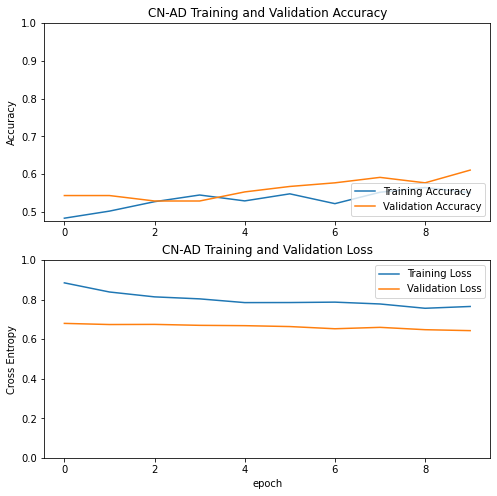

Number of layers in the base model:  814
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb7 (Functional)  (None, 7, 7, 2560)       64097687  
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2560)              0         
                                                                 
 batch_normalization (BatchN  (None, 2560)             10240     
 ormalization)      

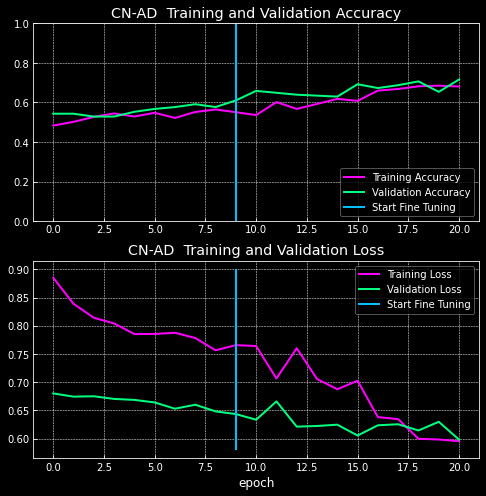

Found 1804 files belonging to 3 classes.
Using 1444 files for training.
Found 1804 files belonging to 3 classes.
Using 360 files for validation.
Number of validation batches: 10
Number of test batches: 2
['AD', 'CN', 'MCI']
(32, 7, 7, 2560)
(32, 2560)
(32, 3)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetb7 (Functional)  (None, 7, 7, 2560)       64097687  
                                                                 
 global_average_pooling2d_1   (None, 2560)             0         
 (GlobalAveragePooling2D)                                        
                                                               

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


10/10 [==============================] - 15s 113ms/step - loss: 1.0954 - accuracy: 0.3446
initial loss: 1.10
initial accuracy: 0.34
Epoch 1/10
46/46 [==============================] - 41s 498ms/step - loss: 1.4878 - accuracy: 0.3483 - val_loss: 1.0983 - val_accuracy: 0.3243
Epoch 2/10
46/46 [==============================] - 6s 127ms/step - loss: 1.4557 - accuracy: 0.3698 - val_loss: 1.0834 - val_accuracy: 0.3885
Epoch 3/10
46/46 [==============================] - 6s 128ms/step - loss: 1.4614 - accuracy: 0.3421 - val_loss: 1.0872 - val_accuracy: 0.3818
Epoch 4/10
46/46 [==============================] - 6s 128ms/step - loss: 1.4003 - accuracy: 0.3407 - val_loss: 1.0901 - val_accuracy: 0.3581
Epoch 5/10
46/46 [==============================] - 6s 127ms/step - loss: 1.3922 - accuracy: 0.3421 - val_loss: 1.1054 - val_accuracy: 0.3682
Epoch 6/10
46/46 [==============================] - 6s 128ms/step - loss: 1.3819 - accuracy: 0.3643 - val_loss: 1.0910 - val_accuracy: 0.4122
Epoch 7/10
46/4

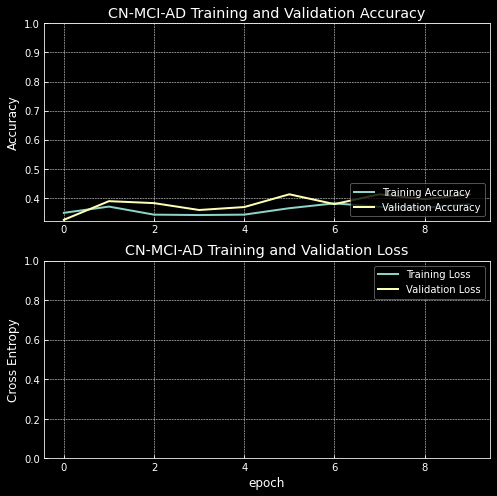

Number of layers in the base model:  814
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetb7 (Functional)  (None, 7, 7, 2560)       64097687  
                                                                 
 global_average_pooling2d_1   (None, 2560)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2560)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 2560)             10240     
 hNormalization)  

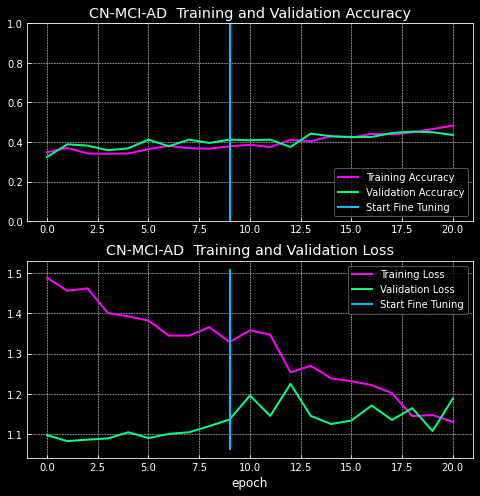

In [ ]:
CN_AD_model, CN_AD_history  = CN_AD_model()
CN_MCI_AD_model, CN_MCI_AD_history  = CN_MCI_AD_model()

# Results

In [ ]:
loss, accuracy = CN_AD_model.evaluate(test_dataset_CN_AD)
print('CN-AD Test accuracy :', accuracy)

loss, accuracy = CN_MCI_AD_model.evaluate(test_dataset_CN_MCI_AD)
print('AN-MCI-AD Test accuracy :', accuracy)

1/1 [==============================] - 0s 250ms/step - loss: 0.6625 - accuracy: 0.6875
CN-AD Test accuracy : 0.6875
2/2 [==============================] - 0s 98ms/step - loss: 1.2221 - accuracy: 0.4375
AN-MCI-AD Test accuracy : 0.4375


CN-AD 

In [ ]:
image_batch_CN_AD, label_batch_CN_AD = test_dataset_CN_AD.as_numpy_iterator().next()
predictions_CN_AD = CN_AD_model.predict_on_batch(image_batch_CN_AD).flatten()

# Aplicar sigmoid ya que nuestro modelo devuelve logits
predictions_CN_AD = tf.nn.sigmoid(predictions_CN_AD)
predictions_CN_AD = tf.where(predictions_CN_AD < 0.5, 0, 1)

print('Predictions:\n', predictions_CN_AD.numpy())
print('Labels:\n', label_batch_CN_AD)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch_CN_AD[i].astype("uint8"))
#   plt.title(class_names_CN_AD[predictions_CN_AD[i]])
#   plt.axis("off")

Predictions:
 [1 0 0 0 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1]
Labels:
 [0 0 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 1 0 0 0 1 1 0 1 0 1 1]


CN-MCI-AD 

In [ ]:
image_batch_CN_MCI_AD, label_batch_CN_MCI_AD = test_dataset_CN_MCI_AD.as_numpy_iterator().next()
predictions_CN_MCI_AD = CN_MCI_AD_model.predict_on_batch(image_batch_CN_MCI_AD)

predictions_CN_MCI_AD = tf.nn.softmax(predictions_CN_MCI_AD)
predictions_CN_MCI_AD = np.argmax(predictions_CN_MCI_AD, axis=1)

print('Predictions:\n', predictions_CN_MCI_AD)
print('Labels:\n', np.argmax(label_batch_CN_MCI_AD, axis=1))

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch_CN_MCI_AD[i].astype("uint8"))
#   plt.title(class_names_CN_MCI_AD[predictions_CN_MCI_AD[i]])
#   plt.axis("off")

Predictions:
 [0 1 0 0 2 1 2 0 0 2 0 0 0 2 0 0 0 0 0 0 1 0 0 0 2 2 0 2 0 2 0 0]
Labels:
 [0 1 1 0 2 2 2 1 2 2 0 2 1 0 0 0 0 2 0 2 2 2 0 1 2 1 1 2 2 0 1 2]


              precision    recall  f1-score   support

          AD       0.64      0.67      0.65        21
          CN       0.30      0.27      0.29        11

    accuracy                           0.53        32
   macro avg       0.47      0.47      0.47        32
weighted avg       0.52      0.53      0.53        32



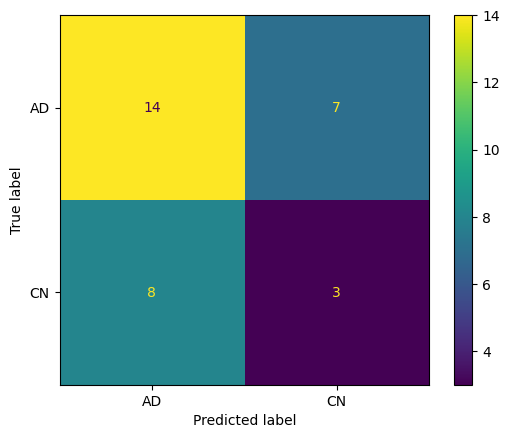

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

print(classification_report(label_batch_CN_AD, predictions_CN_AD, 
                            target_names=class_names_CN_AD))

m_c = tf.math.confusion_matrix(
  label_batch_CN_AD,
  predictions_CN_AD
)
disp = ConfusionMatrixDisplay(confusion_matrix=m_c.numpy(),
                              display_labels=class_names_CN_AD)
plt.style.use('default')
disp.plot()
plt.show()

              precision    recall  f1-score   support

          AD       0.48      0.62      0.54        16
          CN       1.00      0.10      0.18        10
         MCI       0.20      0.33      0.25         6

    accuracy                           0.41        32
   macro avg       0.56      0.35      0.32        32
weighted avg       0.59      0.41      0.37        32



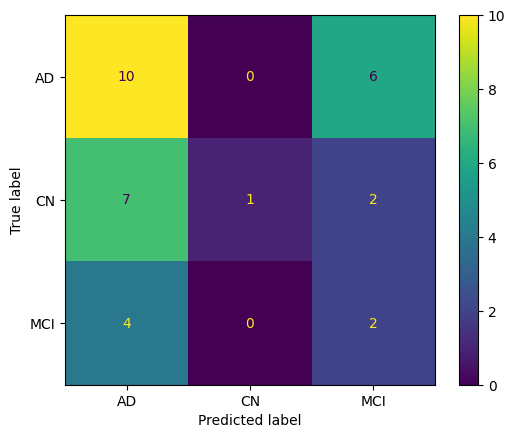

(None,)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

y_true = np.argmax(label_batch_CN_MCI_AD, axis=1)
y_pred = predictions_CN_MCI_AD
print(classification_report(y_true, y_pred, 
                            target_names=class_names_CN_MCI_AD))
m_c = tf.math.confusion_matrix(
  y_true,
  y_pred
)
disp = ConfusionMatrixDisplay(confusion_matrix=m_c.numpy(),
                              display_labels=class_names_CN_MCI_AD)
disp.plot()

plt.show(),